In [1]:
import numpy as np
from subprocess import check_output
from tqdm import tqdm
from skimage.transform import resize
from skimage.morphology import label
from skimage.io import imread, imshow, imread_collection, concatenate_images
%matplotlib inline


size_height = 256
size_width = 256
size_channel = 3

#train_image_id = check_output(["ls", "stage1_train/"]).decode("utf8").split()
test_image_id = check_output(["ls", "stage1_test/"]).decode("utf8").split()

#X_train = np.zeros((len(train_image_id), size_height, size_width, size_channel), dtype=np.uint8)
X_test = np.zeros((len(test_image_id), size_height, size_width, size_channel), dtype=np.uint8)
#Y_train = np.zeros((len(train_image_id), size_height, size_width, 1), dtype=np.bool)

In [2]:
#for ii, image_id in tqdm(enumerate(train_image_id), total=len(train_image_id)):
#    path = "stage1_train/{}/images/{}.png".format(image_id,image_id)
#    image = imread(path)[:,:,:size_channel]
#    image = resize(image, (size_height, size_width), mode='constant', preserve_range=True)
#    X_train[ii] = image
#    mask_path = "stage1_train/{}/masks/*.png".format(image_id)
#    mask = np.zeros((size_height, size_width, 1), dtype=np.bool)
#    masks = imread_collection(mask_path).concatenate()
#    for msk in masks:
#        msk = np.expand_dims(resize(msk, (size_height, size_width), mode='constant', \
#              preserve_range=True), axis=-1)
#        mask = np.maximum(mask, msk)
#    Y_train[ii] = mask

In [3]:
original_size = []
for ii, image_id in tqdm(enumerate(test_image_id), total=len(test_image_id)):
    path = "stage1_test/{}/images/{}.png".format(image_id,image_id)
    image = imread(path)[:,:,:size_channel]
    original_size.append(image.shape)
    image = resize(image, (size_height, size_width), mode='constant', preserve_range=True)
    X_test[ii] = image

100%|██████████| 65/65 [00:02<00:00, 28.50it/s]


In [4]:
import tensorflow as tf
from keras import backend as K
import keras
import matplotlib.pyplot as plt

# Define metrics and loss function
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

Using TensorFlow backend.


In [5]:
model = keras.models.load_model('modelelu.hdf5', custom_objects={'mean_iou':mean_iou})

In [6]:
Y_test = model.predict(X_test)
Y_test_normal = []

for i in tqdm(range(len(Y_test))):
    Y_test_normal.append(resize(np.squeeze(Y_test[i]), (original_size[i][0], original_size[i][1]),\
                        mode='constant', preserve_range=True))

100%|██████████| 65/65 [00:00<00:00, 96.97it/s] 


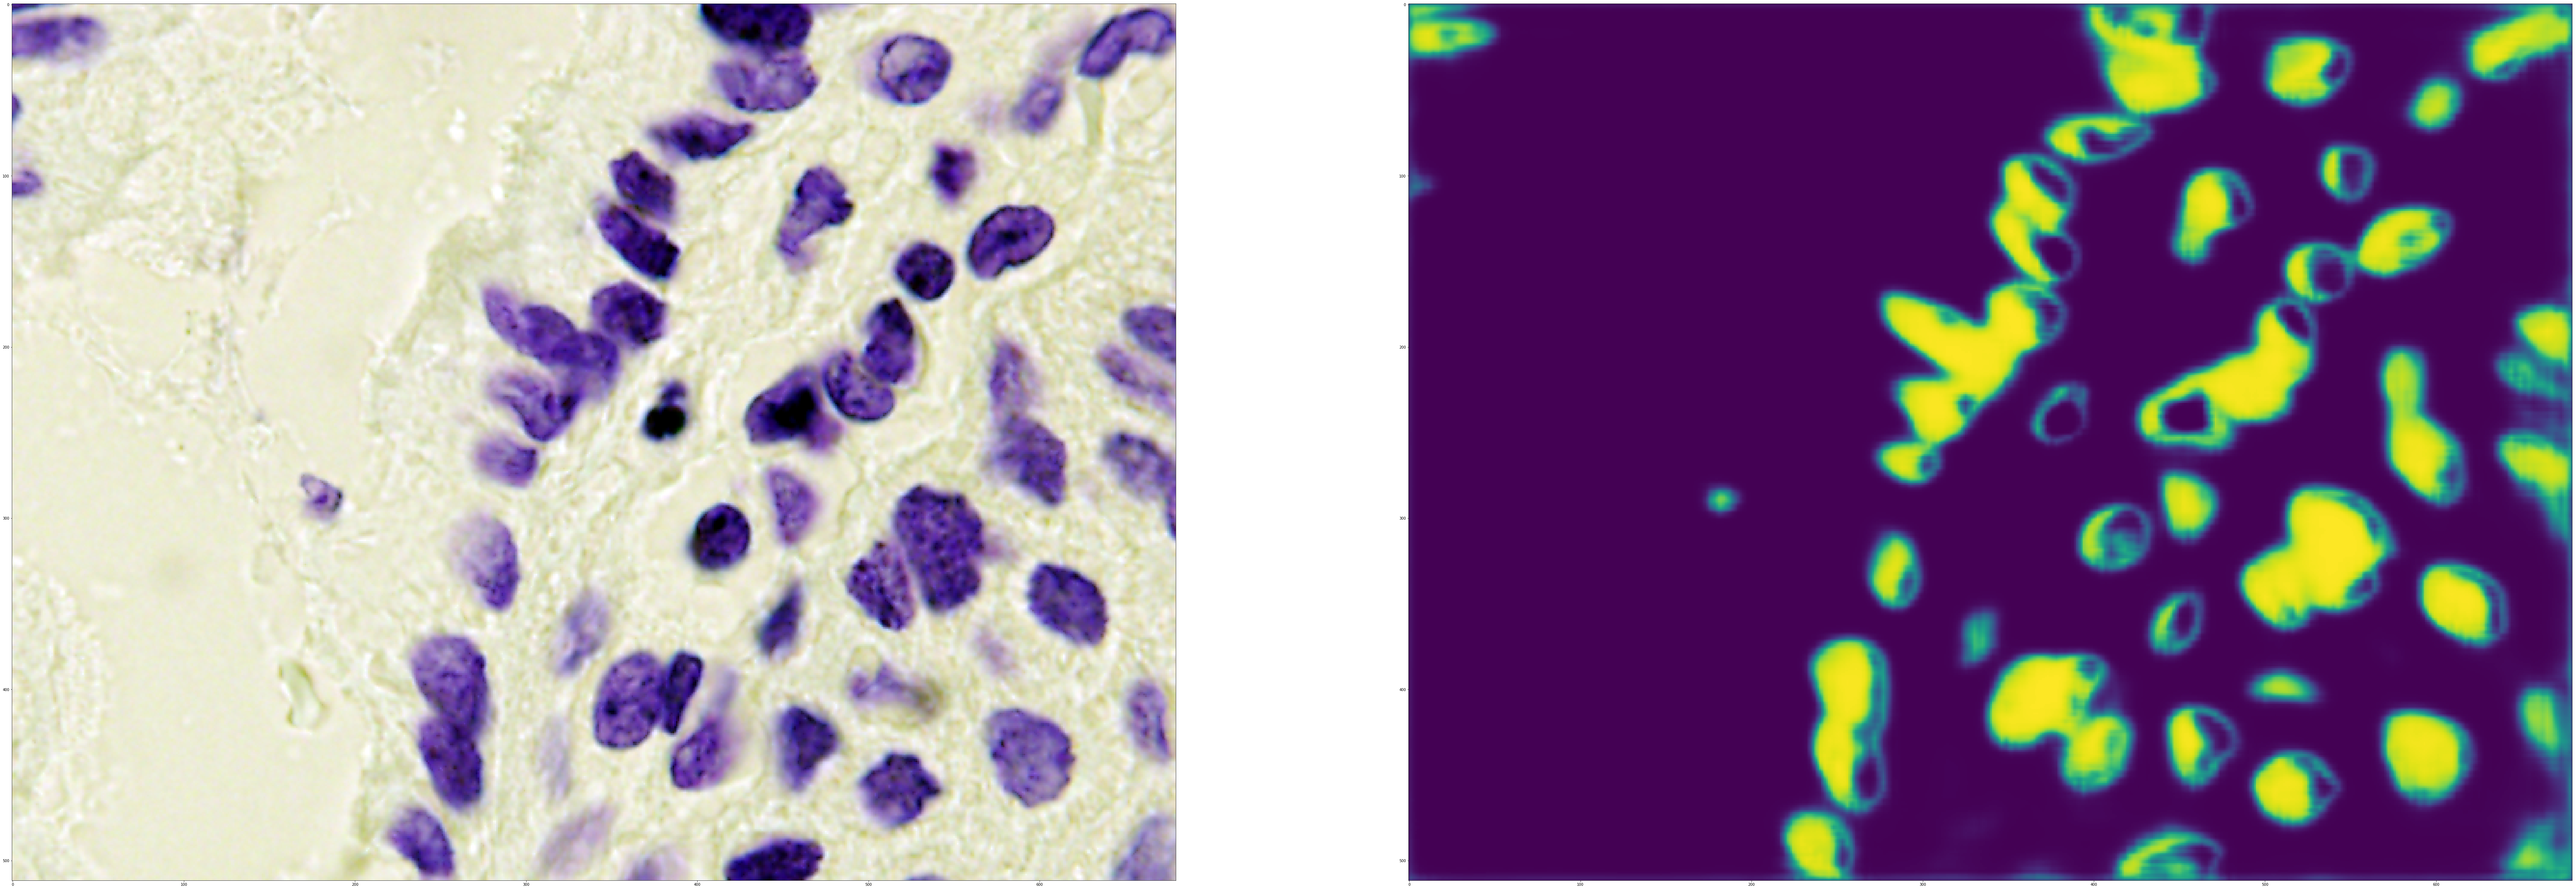

In [7]:
id = 22

image_id = test_image_id[id]
path = "stage1_test/{}/images/{}.png".format(image_id,image_id)
image = imread(path)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(128,128))
ax[0].imshow(image)
ax[1].imshow(Y_test_normal[id])

In [8]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [9]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_image_id):
    rle = list(prob_to_rles(Y_test_normal[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [10]:
import pandas as pd

submit = pd.DataFrame()
submit['ImageId'] = new_test_ids
submit['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
submit.to_csv('submit.csv', index=False)